<a href="https://colab.research.google.com/github/SidharthBhakth/Feedforward-NNs-in-pyTorch/blob/main/05_Self_Supervised_Learning_via_Pretext_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR-10 Self-Supervised Learning via Pretext Tasks**

In [ ]:
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
torch.manual_seed(42)

In [ ]:
# Check if GPU is available
print(torch.cuda.is_available())

# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [ ]:
# Load CIFAR10 data
trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

train, unlabeled = torch.utils.data.random_split(trainset, [500, 49500])

testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def apply_transforms(data, transform):
  
    X = []
    y = []

    for image, label in data:
        image = transform(image)
        X.append(image)
        y.append(label)
  
    return torch.stack(X), torch.tensor(y)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    """
    Custom class to apply transforms
    """
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __getitem__(self, idx):
        # Generates one sample of data
        image, label = self.images[idx], self.labels[idx]

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = (5, 5), stride = 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = (2, 2), stride = 2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (5, 5), stride = 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = (2, 2), stride = 2))
                
        self.fc1 = nn.Linear(in_features = 5 * 5 * 10, out_features = 20)

        self.fc2 = nn.Linear(in_features = 20, out_features = 3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x
  
def init_kaiming(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

**Pretext**

In [ ]:
# Class 0: normalize
X_class_0, _ = apply_transforms(data = unlabeled, transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
Y_class_0 = torch.tensor([0] * len(X_class_0))

# Class 1: flip all images upside down
X_class_1, _ = apply_transforms(data = unlabeled, transform = transforms.Compose([transforms.RandomVerticalFlip(p=1.0),
                                                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
Y_class_1 = torch.tensor([1] * len(X_class_1))

# Class 2: rotate images 90 degree counter-clockwise
X_class_2, _ = apply_transforms(data = unlabeled, transform = transforms.Compose([transforms.ToPILImage(),
                                                                                  transforms.RandomRotation(degrees=(90, 90)),
                                                                                  transforms.ToTensor(),
                                                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
Y_class_2 = torch.tensor([2] * len(X_class_2))

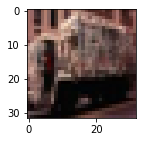

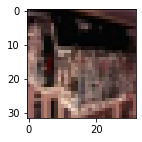

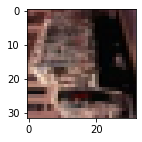

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.figure(figsize = (2,2))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show();

# visualize random training images
idx = np.random.randint(0, 49500)
for dataset in [X_class_0, X_class_1, X_class_2]:
    imshow(make_grid(dataset[idx]))

In [ ]:
X_train = torch.cat([X_class_0, X_class_1, X_class_2], 0)
Y_train = torch.cat([Y_class_0, Y_class_1, Y_class_2], 0)

train_set = Dataset(X_train, Y_train)
train_loader = DataLoader(train_set, batch_size=500, shuffle = True)

In [ ]:
## Training loop 

# Initilize NN class
NN = ConvNet()
NN.apply(init_kaiming)

# Transfer to GPU
NN.to(device)

# hyperparameters
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(NN.parameters(), lr=0.001)
n_epochs = 100

for epoch in range(n_epochs):
    
    # Train
    NN.train()
    for images, labels in train_loader:        
        X_train, Y_train = images.to(device), labels.to(device)               # Transfer to GPU
        optimizer.zero_grad()                                                 # Set the parameter gradients to zero
        output = NN(X_train)                                                  # Forward pass
        loss = loss_fn(output, Y_train)                                       # Compute loss
        loss.backward()                                                       # Backpropagation
        optimizer.step()                                                      # Optimization

# Save model weights
torch.save(NN.state_dict(), 'NN_pretext.h5')

**Baseline**

In [ ]:
X_train, Y_train = apply_transforms(data = train, transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
train_set = Dataset(X_train, Y_train)
train_loader = DataLoader(train_set, batch_size=500, shuffle = True)

X_test, Y_test = apply_transforms(data = testset, transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
test_set = Dataset(X_test, Y_test)
test_loader = DataLoader(test_set, batch_size=500, shuffle = True)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = (5, 5), stride = 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = (2, 2), stride = 2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (5, 5), stride = 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = (2, 2), stride = 2))
                
        self.fc1 = nn.Linear(in_features = 5 * 5 * 10, out_features = 20)

        self.fc2 = nn.Linear(in_features = 20, out_features = 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x
  
def init_kaiming(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
## Training loop 

# Initilize NN class
NN = ConvNet()
NN.apply(init_kaiming)

# Transfer to GPU
NN.to(device)

# hyperparameters
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(NN.parameters(), lr=0.001)
n_epochs = 10000

test_accuracy = []

for epoch in range(n_epochs):
    
    # Train
    NN.train()
    for images, labels in train_loader:        
        X_train, Y_train = images.to(device), labels.to(device)               # Transfer to GPU
        optimizer.zero_grad()                                                 # Set the parameter gradients to zero
        output = NN(X_train)                                                  # Forward pass
        loss = loss_fn(output, Y_train)                                       # Compute loss
        loss.backward()                                                       # Backpropagation
        optimizer.step()                                                      # Optimization
        
    # Test
    NN.eval()
    with torch.no_grad():
      accuracy = 0
      for images, labels in test_loader:
        X_test, Y_test = images.to(device), labels.to(device)                 # Transfer to GPU
        prediction = NN(X_test)                                               # Predict
        Y_pred = torch.argmax(prediction, dim=1)                              # For each prediction, find the dim with the maximum probability
        accuracy_ = 100 * (sum(Y_pred == Y_test).item() / len(Y_test))        # Compute accuracy
        accuracy += accuracy_

    # Keep track of validation accuracy for each epoch
    test_accuracy.append(accuracy/len(test_loader))

    if (epoch+1) % 100 == 0:
        print("Epoch {} | test accuracy: {:.2f}%".format(epoch+1, test_accuracy[-1]))

Epoch 100 | test accuracy: 31.83%
Epoch 200 | test accuracy: 31.04%
Epoch 300 | test accuracy: 30.84%
Epoch 400 | test accuracy: 30.85%
Epoch 500 | test accuracy: 30.84%
Epoch 600 | test accuracy: 30.78%
Epoch 700 | test accuracy: 30.73%
Epoch 800 | test accuracy: 30.72%
Epoch 900 | test accuracy: 30.73%
Epoch 1000 | test accuracy: 30.69%
Epoch 1100 | test accuracy: 30.70%
Epoch 1200 | test accuracy: 30.65%
Epoch 1300 | test accuracy: 30.59%
Epoch 1400 | test accuracy: 30.59%
Epoch 1500 | test accuracy: 30.60%
Epoch 1600 | test accuracy: 30.61%
Epoch 1700 | test accuracy: 30.64%
Epoch 1800 | test accuracy: 30.61%
Epoch 1900 | test accuracy: 30.60%
Epoch 2000 | test accuracy: 30.60%
Epoch 2100 | test accuracy: 30.57%
Epoch 2200 | test accuracy: 30.59%
Epoch 2300 | test accuracy: 30.59%
Epoch 2400 | test accuracy: 30.57%
Epoch 2500 | test accuracy: 30.56%
Epoch 2600 | test accuracy: 30.54%
Epoch 2700 | test accuracy: 30.54%
Epoch 2800 | test accuracy: 30.58%
Epoch 2900 | test accuracy: 3

**Transfer learning**

In [ ]:
# Load model weights from pretext model
NN_pretext_weights = torch.load('NN_pretext.h5')

# Remove model weights for the last layer
del NN_pretext_weights['fc2.weight']
del NN_pretext_weights['fc2.bias']

In [ ]:
## Training loop 

# Initilize NN class
NN = ConvNet()
NN.load_state_dict(NN_pretext_weights, strict=False)                            # Warmstart model with pretext model weights
NN.fc2.apply(init_kaiming)                                                      # Initialize last layer weights with Kaiming He initialization 

# Transfer to GPU
NN.to(device)

# hyperparameters
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam([{"params": NN.conv1.parameters(), "lr": 1e-5},
                        {"params": NN.conv2.parameters(), "lr": 1e-5},
                        {"params": NN.fc1.parameters(), "lr": 1e-5},
                        {"params": NN.fc2.parameters(), "lr": 1e-3}])

n_epochs = 10000

tl_test_accuracy = []

for epoch in range(n_epochs):
    
    # Train
    NN.train()
    for images, labels in train_loader:        
        X_train, Y_train = images.to(device), labels.to(device)                 # Transfer to GPU
        optimizer.zero_grad()                                                   # Set the parameter gradients to zero
        output = NN(X_train)                                                    # Forward pass
        loss = loss_fn(output, Y_train)                                         # Compute loss
        loss.backward()                                                         # Backpropagation
        optimizer.step()                                                        # Optimization
        
    # Test
    NN.eval()
    with torch.no_grad():
      accuracy = 0
      for images, labels in test_loader:
        X_test, Y_test = images.to(device), labels.to(device)                   # Transfer to GPU
        prediction = NN(X_test)                                                 # Predict
        Y_pred = torch.argmax(prediction, dim=1)                                # For each prediction, find the dim with the maximum probability
        accuracy_ = 100 * (sum(Y_pred == Y_test).item() / len(Y_test))          # Compute accuracy
        accuracy += accuracy_

    # Keep track of validation accuracy for each epoch
    tl_test_accuracy.append(accuracy/len(test_loader))

    if (epoch+1) % 100 == 0:
        print("Epoch {} | test accuracy: {:.2f}%".format(epoch+1, tl_test_accuracy[-1]))

Epoch 100 | test accuracy: 12.46%
Epoch 200 | test accuracy: 17.95%
Epoch 300 | test accuracy: 22.02%
Epoch 400 | test accuracy: 26.28%
Epoch 500 | test accuracy: 28.66%
Epoch 600 | test accuracy: 29.98%
Epoch 700 | test accuracy: 30.93%
Epoch 800 | test accuracy: 31.85%
Epoch 900 | test accuracy: 32.22%
Epoch 1000 | test accuracy: 32.84%
Epoch 1100 | test accuracy: 33.29%
Epoch 1200 | test accuracy: 33.41%
Epoch 1300 | test accuracy: 33.57%
Epoch 1400 | test accuracy: 33.50%
Epoch 1500 | test accuracy: 33.61%
Epoch 1600 | test accuracy: 33.77%
Epoch 1700 | test accuracy: 33.80%
Epoch 1800 | test accuracy: 33.89%
Epoch 1900 | test accuracy: 33.90%
Epoch 2000 | test accuracy: 34.05%
Epoch 2100 | test accuracy: 34.09%
Epoch 2200 | test accuracy: 34.27%
Epoch 2300 | test accuracy: 34.36%
Epoch 2400 | test accuracy: 34.29%
Epoch 2500 | test accuracy: 34.43%
Epoch 2600 | test accuracy: 34.67%
Epoch 2700 | test accuracy: 34.63%
Epoch 2800 | test accuracy: 34.59%
Epoch 2900 | test accuracy: 3

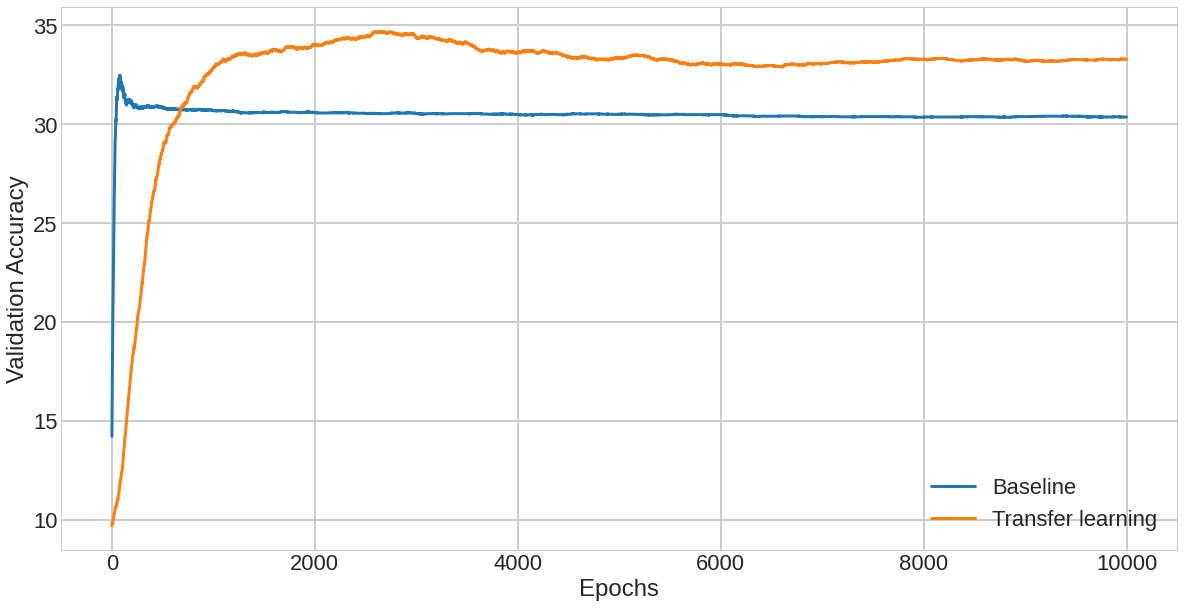

In [ ]:
sns.set_context('poster')
plt.style.use('seaborn-whitegrid')

plt.figure(figsize = (20,10))
plt.plot(test_accuracy, label = 'Baseline')
plt.plot(tl_test_accuracy, label = 'Transfer learning')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right');

We can see from the plot of validation accuracies of both models that transfer leaarning does indeed increase the validation performance.